In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
import hashlib
import datetime
import time
import os
import re
from collections import Counter

In [13]:
# open the api.txt file
with open('api.txt', 'r') as f:
    pub_api = f.read()
# run the api key
with open('priv_api.txt', 'r') as f:
    priv_api = f.read()
timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")


In [14]:
# def hash_params():
#     hash_md5 = hashlib.md5()
#     hash_md5.update(f'{timestamp}{priv_api}{pub_api}'.encode('utf-8'))
#     hashed_params = hash_md5.hexdigest()
#     return hashed_params
CHARACTER_URL = 'http://gateway.marvel.com/v1/public/characters'
def get_hash_and_ts_params():
    ts = str(time.time())
    combined = ''.join([ts, priv_api, pub_api])
    hash_value = hashlib.md5(combined.encode('ascii')).hexdigest()
    return {'ts': ts, 'hash': hash_value}


In [15]:
# params = {'ts': timestamp, 'apikey': pub_api, 'hash': hash_params()}
# response = requests.get("http://gateway.marvel.com/v1/public/comics", params=params)
# print(response.status_code)
def paged_requests(page_size=100):
      params = {'apikey': pub_api, 'limit': page_size}
      character_df = []
      for i in range(16):
          params.update({'limit': page_size})
          hash_params = get_hash_and_ts_params()
          params.update(hash_params)
          params.update({'offset': page_size * i}) # offset, how many records to skip
          resp = requests.get(CHARACTER_URL, params)
          # print(f'Requested page {i} of {page_size} records')
          resp.raise_for_status()  # stop if there are any errors!
        #   print(f'Full request URL: {resp.request.url}')
          j = resp.json()
          character_df.extend(j['data']['results'])
        #   print(f'First ten records: {character_df[:10]}')
      print('Done')
      # character_df = pd.DataFrame(character_df)
      return character_df

if __name__ == '__main__':
    character_df = paged_requests()
    character_df = pd.DataFrame(character_df)
    character_df.to_json('marvel.json', orient='records')
    character_df.to_csv('marvel.csv', index=False)

Done


In [16]:
with open('marvel.json') as f:
    data = json.load(f)

characters = []
for entry in data:
    character = {
        'name': entry['name'],
        # 'description': entry['description'],
        'comics_available': entry['comics']['available'],
        'series_available': entry['series']['available'],
        'stories_available': entry['stories']['available'],
        'events_available': entry['events']['available'] if 'events' in entry else None
    }

    character['comics_items'] = [item['name'] for item in entry['comics']['items']]
    character['series_items'] = [item['name'] for item in entry['series']['items']]
    character['stories_items'] = [item['name'] for item in entry['stories']['items']]
    
    if 'events' in entry:
        character['events_items'] = [item['name'] for item in entry['events']['items']]
    else:
        character['events_items'] = None

    characters.append(character)

df = pd.DataFrame(characters)

In [17]:
df

,name,comics_available,series_available,stories_available,events_available,comics_items,series_items,stories_items,events_items
0,3-D Man,12,3,21,1,"[Avengers: The Initiative (2007) #14, Avengers...","[Avengers: The Initiative (2007 - 2010), Deadp...","[Cover #19947, The 3-D Man!, Cover #19949, The...",[Secret Invasion]
1,A-Bomb (HAS),4,2,7,0,"[FREE COMIC BOOK DAY 2013 1 (2013) #1, Hulk (2...","[FREE COMIC BOOK DAY 2013 1 (2013), Hulk (2008...","[Hulk (2008) #55, Interior #92079, Hulk (2008)...",[]
2,A.I.M.,53,36,57,0,"[Ant-Man & the Wasp (2010) #3, Avengers (1998)...","[Ant-Man & the Wasp (2010 - 2011), Avengers (1...","[Avengers and Power Pack Assemble! (2006) #2, ...",[]
3,Aaron Stack,14,3,27,0,"[Dark Avengers (2012) #177, Dark Avengers (201...","[Dark Avengers (2012 - 2013), Hulk (2008 - 201...","[Universe X (2000) #10, Interior #25635, Unive...",[]
4,Abomination (Emil Blonsky),58,28,68,1,"[Abominations (1996) #1, Abominations (1996) #...","[Abominations (1996 - Present), Avengers (1998...","[4 of 4 - 4XLS, Irredeemable Ant-Man (2006) #1...",[Chaos War]
...,...,...,...,...,...,...,...,...,...
1558,Zeus,36,13,43,0,"[Avengers (1963) #50, Avengers (1963) #283, Av...","[Avengers (1963 - 1996), Avengers No Road Home...","[Whom the Gods Would Destroy, Battleground: O...",[]
1559,Zodiak,1,1,1,0,[Defenders (1972) #50],[Defenders (1972 - 1986)],[Story to Defenders #50],[]
1560,Zombie (Simon Garth),1,1,1,0,[Strange Tales (1998) #1],[Strange Tales (1998)],[],[]
1561,Zuras,3,3,3,0,"[Eternals (1976) #5, Eternals by Jack Kirby (H...","[Eternals (1976 - 1978), Eternals by Jack Kirb...","[ETERNALS (1976) #5, Hulk (2008) #49, Interior...",[]


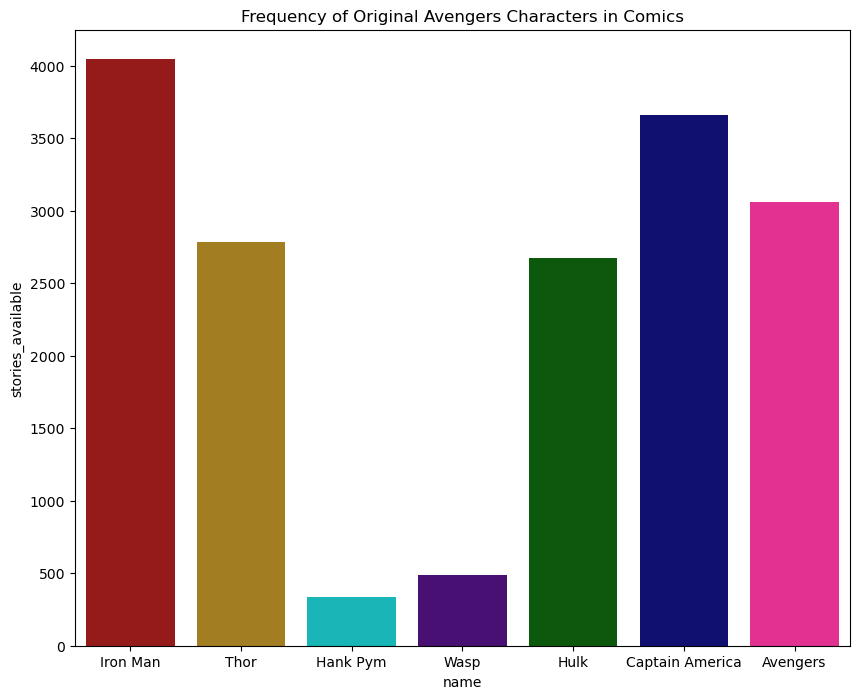

In [142]:
# make a plot showing the frequency of each original avenger character
avengers = [
    "Iron Man", "Thor", "Hank Pym", "Wasp", "Hulk", "Captain America", "Avengers"
]
avenger_colors = {
    "Iron Man": "#aa0505",
    "Thor": "darkgoldenrod",
    "Hank Pym": "darkturquoise",
    "Wasp": "indigo",
    "Hulk": "darkgreen",
    "Captain America": "navy",
    "Avengers": "deeppink"
}

#plot the frequency of each original avenger character in comics
sns.barplot(data=df, x="name", y="stories_available", 
order=avengers, palette=avenger_colors.values()).set_title("Frequency of Original Avengers Characters in Comics")
plt.gcf().set_size_inches(10, 8)
plt.show()

In [19]:
#make a plot of the 5 most popular characters and which stories they appear in
df_sorted = df.sort_values(by="stories_available", ascending=False).head(100)
# df_sorted

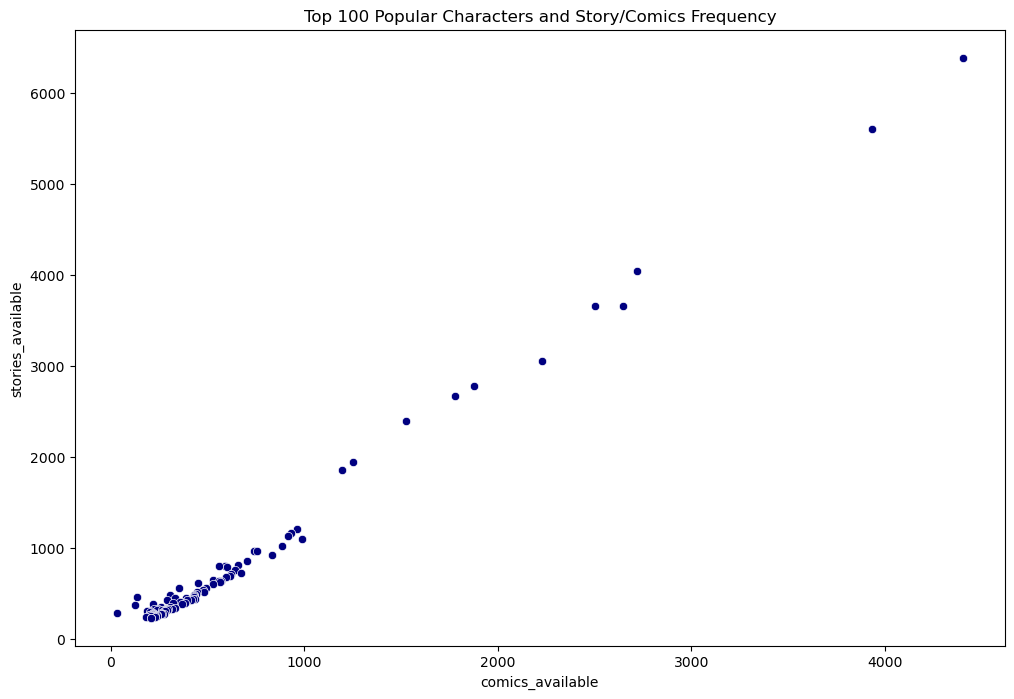

In [20]:
scatter = sns.scatterplot(data=df_sorted, x="comics_available", y="stories_available", color="navy")
scatter.set_title("Top 100 Popular Characters and Story/Comics Frequency")
plt.gcf().set_size_inches(12, 8)
plt.show()

In [22]:
print(f"Marvel Character appearing in most number of stories and comics:\nName: {df_sorted['name'].iloc[0]}\nComics: {df_sorted['comics_available'].iloc[0]}\nStories: {df_sorted['stories_available'].iloc[0]}")

Marvel Character appearing in most number of stories and comics:
Name: Spider-Man (Peter Parker)
Comics: 4402
Stories: 6385


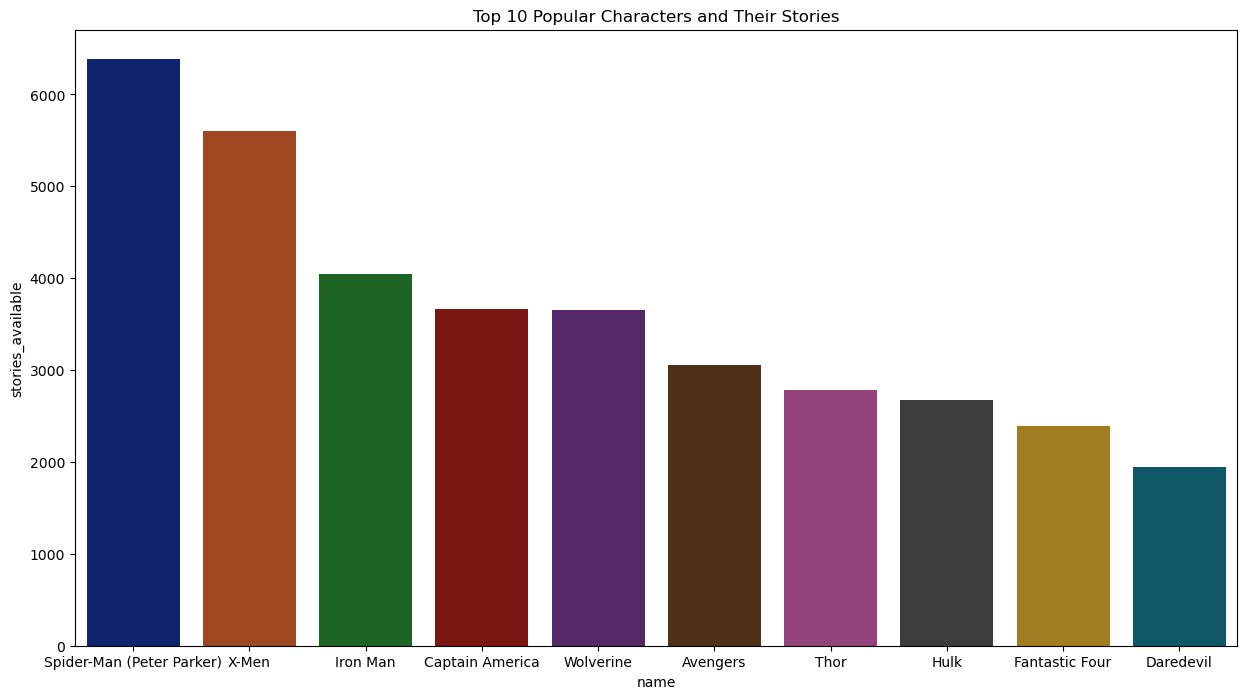

In [23]:
df_sorted_new = df.sort_values(by="stories_available", ascending=False).head(10)
ax = sns.barplot(data=df_sorted_new, x="name", y="stories_available", palette="dark")
ax.set_title("Top 10 Popular Characters and Their Stories")
plt.gcf().set_size_inches(15, 8)
plt.show()

In [94]:
# for loop
# check in the comics
#check for dates in parentheses
#add one to columns once we have the year columns
#np.unique(return_counts = True)
#double for loop
#make a new df for years
# character name column and year columns (0 if no mentions for a year)
years_df = pd.DataFrame(characters, columns=['name']).set_index('name')
years_df

""
name
3-D Man
A-Bomb (HAS)
A.I.M.
Aaron Stack
Abomination (Emil Blonsky)
...
Zeus
Zodiak
Zombie (Simon Garth)


In [96]:
# for character in df['name']:
#     for comic in df['comics_items']:
#         # extract years from comic names
#         #if r'\((\d{4})\)' in comic
#         # add the year to the years_df as a column
#         if not isinstance(comic, str):
#             comic = str(comic)
#         matches = re.findall(r'\((\d{4})\)', comic)
#         for year in matches:
#             if year not in years_df.columns:
#                 years_df[year] = 0
#             years_df.loc[years_df['name'] == character, year] += 1
#             #add year as column to new df
# years_df

def extract_years(comics):
    comics = [str(comic) for comic in comics if isinstance(comic, str)]
    matches = [re.findall(r'\((\d{4})\)', comic) for comic in comics]
    years = [year for match in matches for year in match]
    return years
    # for year in set(years):
    #     if year not in years_df.columns:
    #         years_df[year] = 0
    # for year in set(years):
    #     years_df.loc[years_df['name'].isin(comics), year] += years.count(year)


# df.apply(lambda row: update_years(row['comics_items']), axis=1)


In [130]:
for character in df['name']:
    if character not in years_df.index:
        years_df.loc[character] = 0

character_counts = {character : Counter() for character in years_df.index}

for index, row in df.iterrows():
    years = extract_years(row['comics_items'])
    character_counts[row['name']].update(years)

for character, counts in character_counts.items():
    for year, count in counts.items():
        years_df.loc[character, year] = count
        #if a NaN
years_df = years_df.fillna(0).astype(int)
years_df = years_df.reindex(sorted(years_df.columns, key=lambda x: int(x) if x.isdigit() else float('inf')), axis=1)
years_df

,1939,1940,1941,1945,1948,1949,1950,1951,1952,1953,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
name,,,,,,,,,,,,,,,,,,,,,
3-D Man,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A-Bomb (HAS),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A.I.M.,0,0,0,0,0,0,0,0,0,0,...,0,0,0,4,0,0,0,0,1,0
Aaron Stack,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Abomination (Emil Blonsky),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zeus,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,4,6,0,0,0
Zodiak,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Zombie (Simon Garth),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


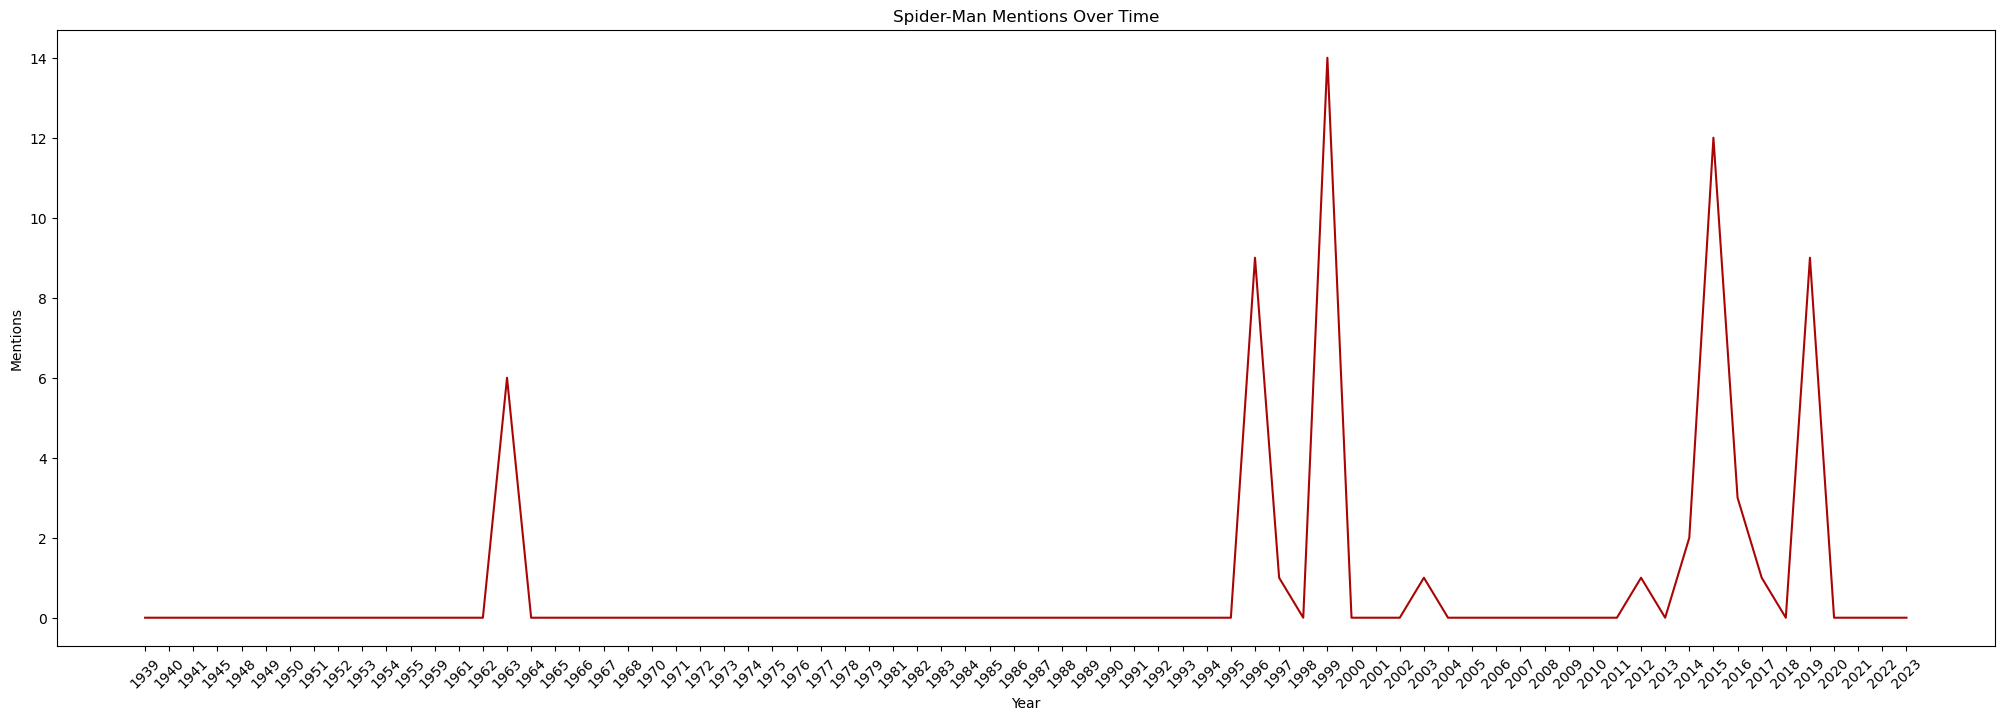

In [209]:
peter = years_df.loc[ ['Peter Parker','Spider-Man (Peter Parker)','Spider-Man (Miles Morales)'] ]
combined_spiderman = peter.sum(axis=0)
#plot the peters on a graph with different color lines for each person
#switch the variable for color to be the name of the character
# peter = peter.transpose()
# peter.plot(color= ['red', 'black', 'blue'])
plt.plot(combined_spiderman.index, combined_spiderman.values, color = "#aa0505")
plt.gcf().set_size_inches(25,8)
plt.title('Spider-Man Mentions Over Time')
plt.xlabel('Year')
plt.ylabel('Mentions')
plt.xticks(rotation=45)
plt.show()

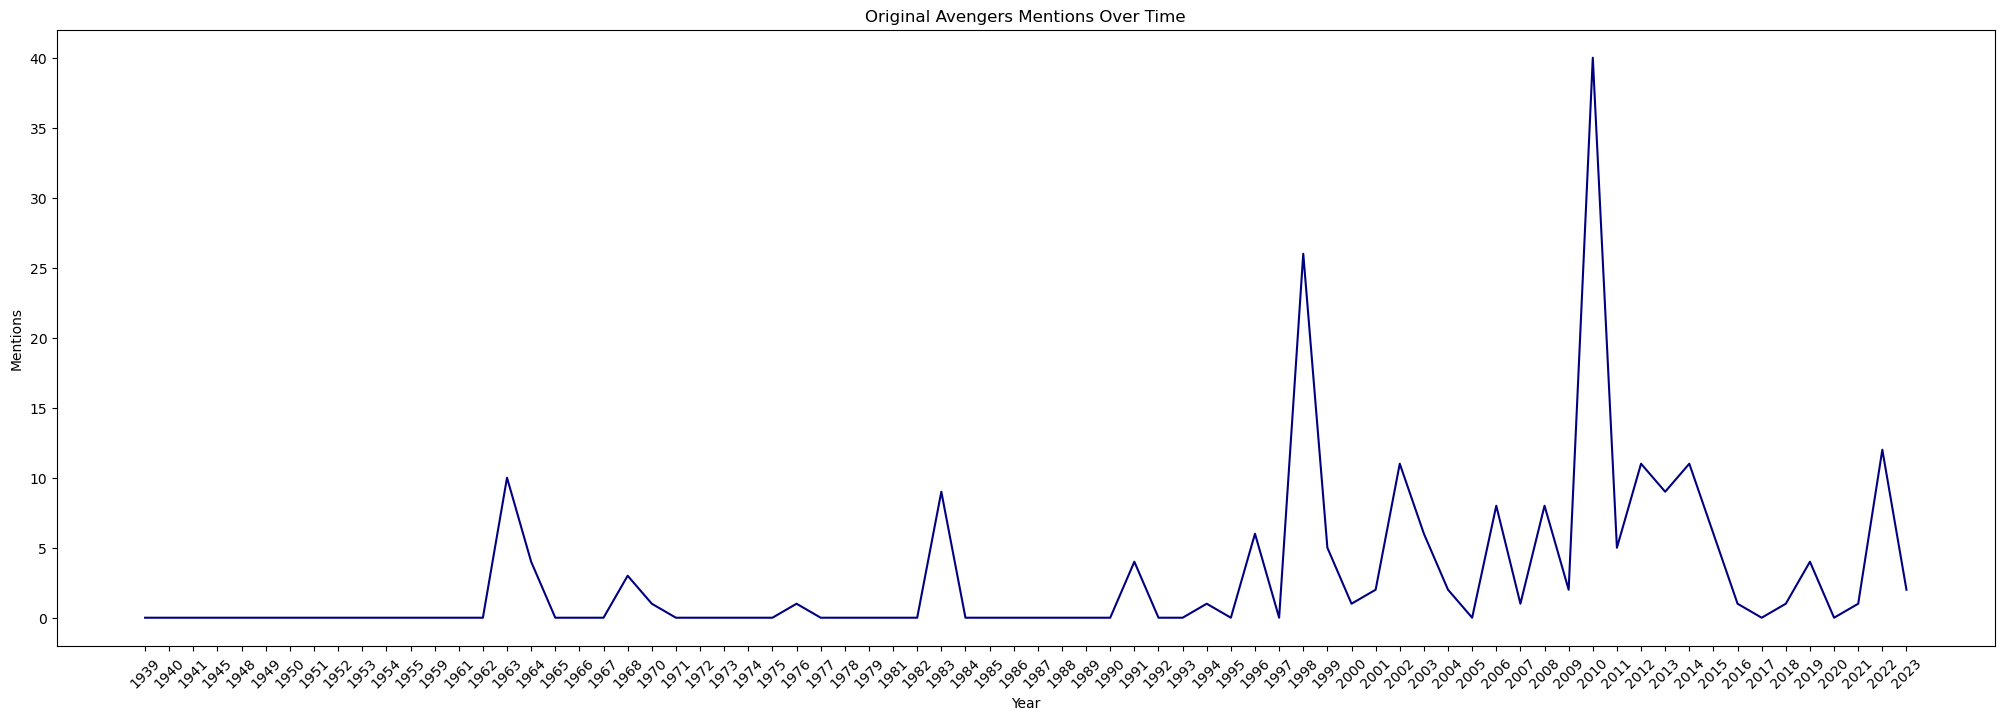

In [224]:
selected_avengers = years_df.loc[["Iron Man", "Thor", "Hank Pym", "Wasp", "Hulk", "Captain America", 
                                  "Avengers", "Steve Rogers", "Tony Stark",  "Bruce Banner", "Ant-Man (Hank Pym)", "Wasp (Ultimate)"]]
# selected_avengers = selected_avengers.transpose()
# selected_avengers.plot(color=avenger_colors)
# plt.title('Avengers Mentions Over Time')
# plt.gcf().set_size_inches(15, 8)
# plt.show()


combined_avengers = selected_avengers.sum(axis=0)
#plot the peters on a graph with different color lines for each person
#switch the variable for color to be the name of the character
# peter = peter.transpose()
# peter.plot(color= ['red', 'black', 'blue'])
plt.plot(combined_avengers.index, combined_avengers.values, color='navy')
plt.gcf().set_size_inches(25,8)
plt.title('Original Avengers Mentions Over Time')
plt.xlabel('Year')
plt.ylabel('Mentions')
plt.xticks(rotation=45)
plt.show()

Text(0.5, 1.0, 'Captain America Mentions Over Time')

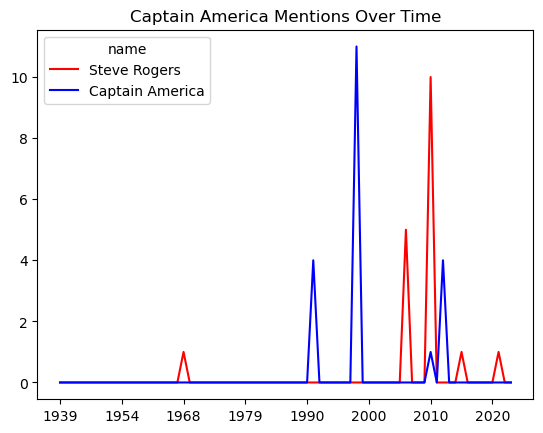

In [156]:
steve = years_df.loc[ ['Steve Rogers','Captain America'] ]
steve = steve.transpose()
steve.plot(color= ['red','blue'])
plt.title('Captain America Mentions Over Time')